# 3D Rendering
* Raster drawing (2D)
* Projecting a point cloud
* Rotations
* Drawing a triangle
* Mesh representation
* Z-buffering
* Darth Vader

## Raster drawing

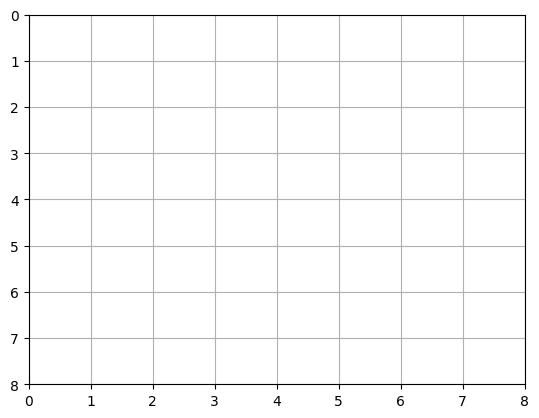

In [419]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True)); ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlim([0, 8])
ax.set_ylim([8, 0])
plt.grid()

In [2]:
import numpy as np

In [294]:
resolution = 320, 200
w, h = resolution
# Allocate a byte buffer. 0 = black, 255 = white
buffer = np.zeros((h, w, 1), dtype=np.uint8)

In [295]:
n = 512
np.random.seed(17)  # official KTH random number
pixels = 0.5 * np.array(resolution) + np.random.normal(size=(n, 2)) * 24

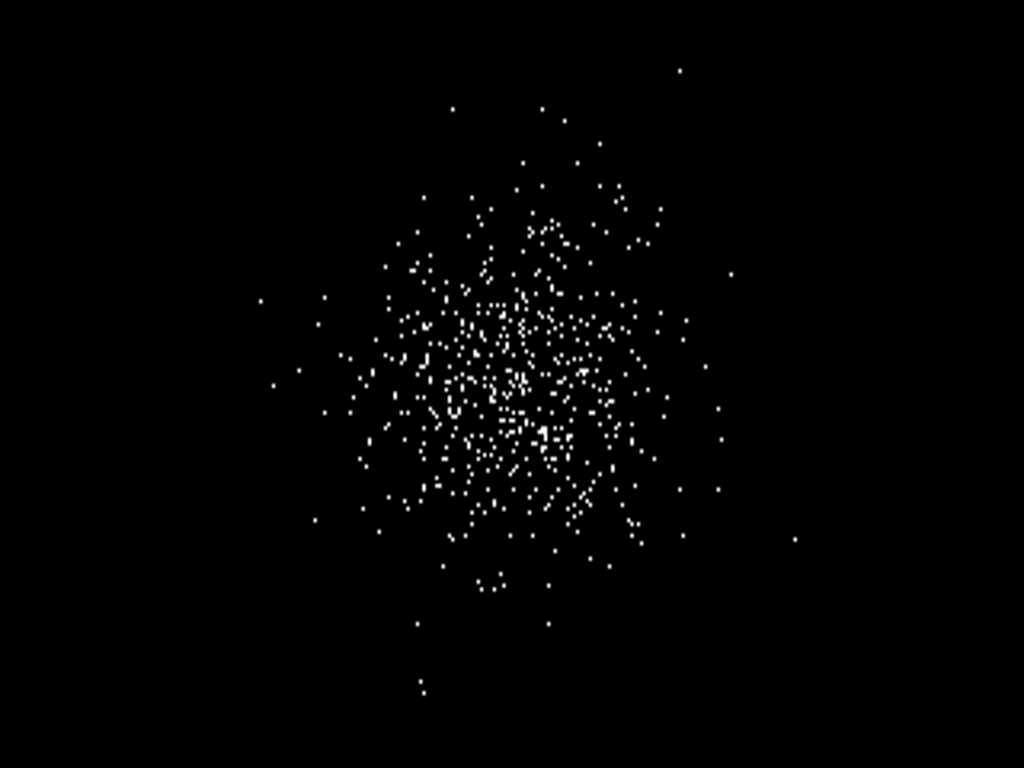

In [420]:
from typing import Tuple

def create_buffer(resolution: Tuple[int, int]):
    w, h = resolution
    return np.zeros((h, w, 3), dtype=np.uint8)

def draw_pixels(buffer: np.ndarray, pixels: np.ndarray) -> None:
    assert pixels.shape[1] == 2
    h, w, _ = buffer.shape
    for sx, sy in pixels.astype(int):
        if 0 < sx < w and 0 < sy < h:
            buffer[sy, sx] = 255, 255, 255

def show_buffer(buffer: np.ndarray) -> None:
    return Image.fromarray(buffer).resize((1024, 768))
    
buffer = create_buffer(resolution)
draw_pixels(buffer, pixels)
show_buffer(buffer)

## Projection

In [421]:
vertices = np.random.normal(size=(n, 3))

In [422]:
def orthographic(vertices: np.ndarray) -> np.ndarray:
    assert vertices.shape[1] == 3
    # just drop (ignore) z values
    return vertices[:, :2]  # first column means return all rows, :2 means return first two columns (but not the third which is z)

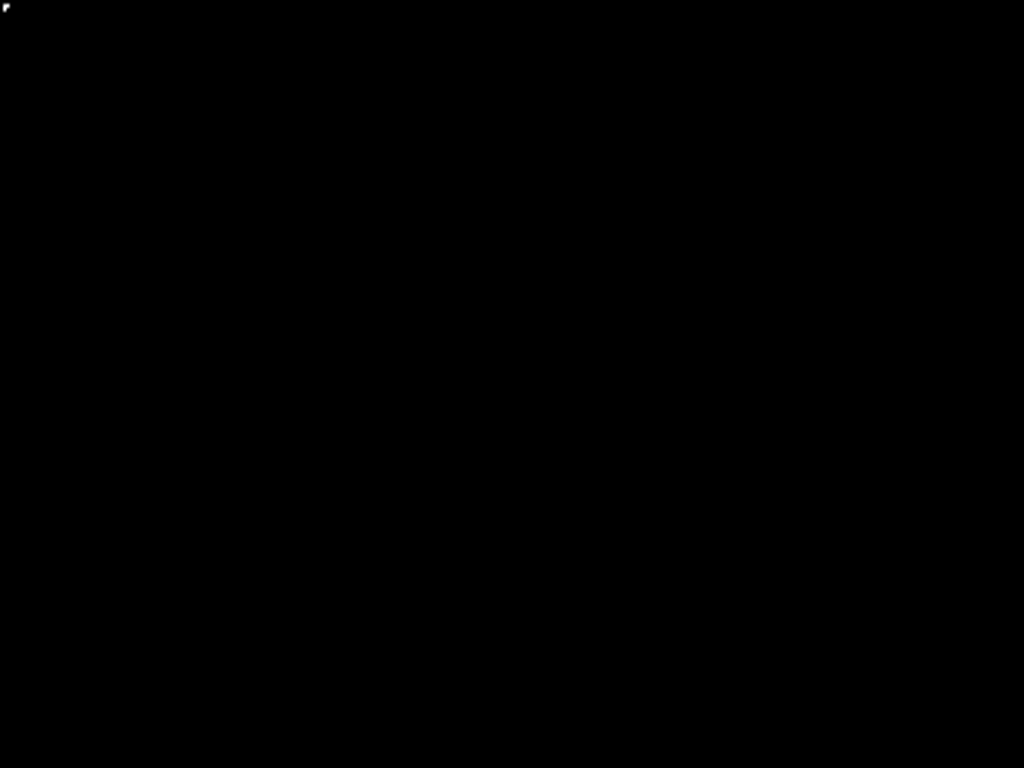

In [423]:
buffer = create_buffer(resolution)
draw_pixels(buffer, orthographic(vertices))
show_buffer(buffer)

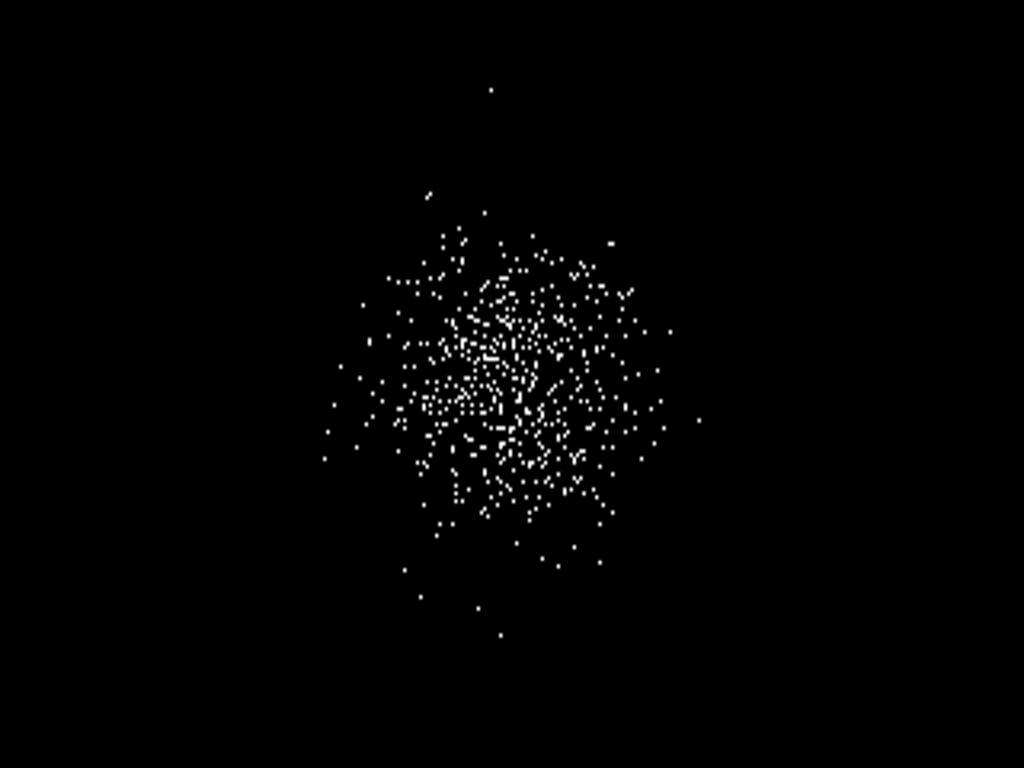

In [424]:
def to_screen(ndc: np.ndarray, resolution: Tuple[int, int]) -> np.ndarray:
    """Transforms pixels from the NDC cordinate system (-1 to 1) to the specificed resolution"""
    scale = np.min(resolution)
    return 0.5 * np.array(resolution) + scale * ndc

vertices = np.random.normal(size=(n, 3)) * 0.1  # smaller point cloud so it fits within the resolution
buffer = create_buffer(resolution)
draw_pixels(buffer, to_screen(orthographic(vertices), resolution))
show_buffer(buffer)

In [425]:
def transform(m: np.ndarray, points: np.ndarray) -> np.ndarray:
    """Transforms all points in `points` according to the transformation matrix `m`"""
    assert points.shape[1] == 3
    return (np.dot(m, points.T)).T

In [426]:
from math import cos, sin, pi
tau = 2 * pi

theta = 1/8 * tau
def rotate_y(theta: float) -> np.ndarray:
    return np.array([
        [cos(theta), 0, -sin(theta)],
        [         0, 1,          0],
        [sin(theta), 0,  cos(theta)],
    ])

transform(rotate_y(theta), vertices)

array([[-0.05345411,  0.05655773,  0.02731419],
       [ 0.08510769,  0.07773991, -0.09969423],
       [-0.08461247,  0.14182202,  0.05824632],
       ...,
       [ 0.06166609,  0.07617433, -0.08772915],
       [-0.05397064, -0.06200183,  0.20632538],
       [-0.04208747,  0.01268085, -0.06193551]])

In [427]:
# Some iphython stuff to display gifs
from typing import List
import IPython.display

def display_gif(frames: List[np.ndarray], framerate: float, **kwargs) -> IPython.display.Image:
    images = [Image.fromarray(frame) for frame in frames]
    images[0].save('1.gif', save_all=True, append_images=images[1:], duration=framerate * len(images), loop=0)
    return IPython.display.Image(url="1.gif", **kwargs)

In [430]:
def draw_frame(m: np.ndarray, vertices: np.ndarray, project: Callable[[np.ndarray], np.ndarray]) -> np.ndarray:
    buffer = np.zeros((h, w, 3), dtype=np.uint8)  # create new frame
    transformed = transform(m, vertices)  # transform vertices
    ndc = project(transformed)  # project vertices into ndc
    pixels = to_screen(ndc, resolution)  # convert to screen space (resolution of buffer)
    draw_pixels(buffer, pixels)  # draw pixels
    return buffer

#vertices = np.random.uniform(-1, 1, size=(n, 3)) * 0.1
#vertices = np.random.normal(size=(n, 3)) * 0.1

transforms = (rotate_y(theta) for theta in np.linspace(0, tau, 200))
frames = [draw_frame(transform, vertices, project=orthographic) for transform in transforms]
display_gif(frames, framerate=1/30, width=1024)

## Perspective
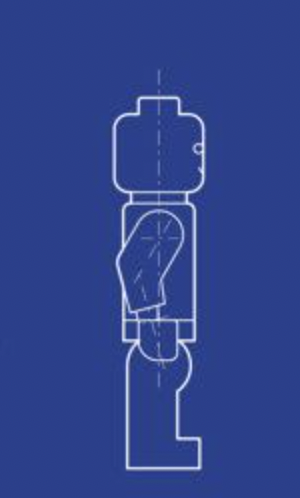

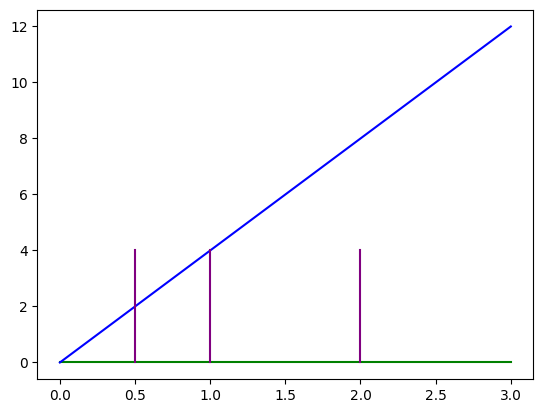

In [431]:
plt.plot([0, 3], [0, 0], 'green')  # ground
plt.plot([0, 3], [0, 12], 'blue')  # line of sight
plt.plot([1, 1], [0, 4], 'purple')  # minifig at z=1
plt.plot([2, 2], [0, 4], 'purple')  # minifig at z=2
plt.plot([0.5, 0.5], [0, 4], 'purple')  # minifig at z=0.5

Apparent height $y = h / z$

In [367]:
def perspective(vertices: np.ndarray) -> np.ndarray:
    z = vertices[:, 2][:, np.newaxis]  # all z-values
    return vertices[:, :2] / z  # pick x and y values and divide each row (vertex) with the corresponding z-value

In [432]:
transforms = (rotate_y(theta) for theta in np.linspace(0, tau, 200))
frames = [draw_frame(transform, vertices, project=perspective) for transform in transforms]
display_gif(frames, framerate=1/30, width=512)

In [433]:
# updated function with a translation parameter t
def draw_frame(m: np.ndarray, t: np.ndarray, vertices: np.ndarray, project: Callable[[np.ndarray], np.ndarray]) -> np.ndarray:
    buffer = np.zeros((h, w, 3), dtype=np.uint8)  # create new frame
    transformed = transform(m, vertices) + t # transform vertices
    ndc = project(transformed)  # project vertices into ndc
    pixels = to_screen(ndc, resolution)  # convert to screen space (resolution of buffer)
    draw_pixels(buffer, pixels)  # draw pixels
    return buffer

In [501]:
t = np.array([0, 0, 0.5])
transforms = (rotate_y(theta) for theta in np.linspace(0, tau, 200))
frames = [draw_frame(transform, t, vertices, project=perspective) for transform in transforms]
display_gif(frames, framerate=1/30, width=512)

## Triangles

[ 0.14324277  0.1188954  -0.13408968] [ 0.11374901 -0.0480629  -0.05539692]


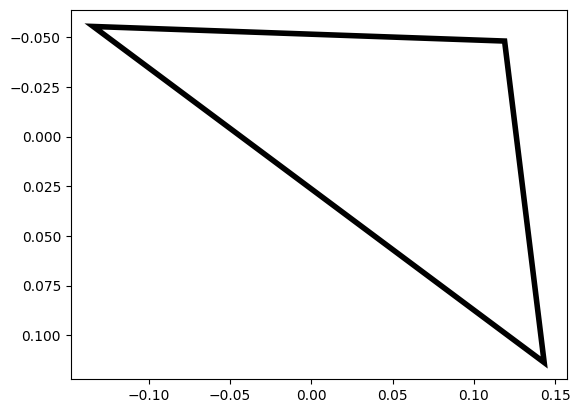

In [484]:
triangle = (0, 1, 2)  # pick the first three vertices to work with
xs = vertices[triangle, 0]
ys = vertices[triangle, 1]
print(xs, ys)
plt.fill(xs, ys, fill=False, lw=4)
plt.gca().invert_yaxis()

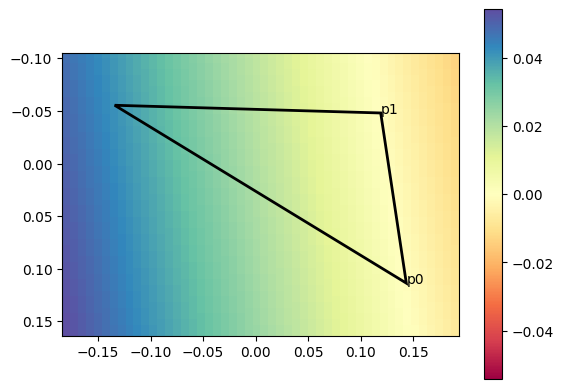

In [571]:
# barycentric cordinates
def edge(p0: np.ndarray, p1: np.ndarray, p: np.ndarray) -> float:
    """Computes the edge function at point p for the edge p0 -> p1. Arguments are either (1, 2) arrays or
    (n, 2) arrays. Broadcasting rules apply."""
    assert all(a.shape[1] == 2 for a in (p0, p1, p))  # all arrays must have two columns
    return (p[:, 0] - p0[:, 0]) * (p1[:, 1] - p0[:, 1])  - (p[:, 1] - p0[:, 1]) * (p1[:, 0] - p0[:, 0])

# find the bounding box
xmin, xmax = np.min(xs), np.max(xs)
ymin, ymax = np.min(ys), np.max(ys)
# some padding
padding = 0.05
xmin, xmax = xmin - padding, xmax + padding
ymin, ymax = ymin - padding, ymax + padding
X, Y = np.meshgrid(np.linspace(xmin, xmax), np.linspace(ymin, ymax))  # arrange a gridspace on the bounding box
i0, i1 = 0, 1
p0, p1 = vertices[triangle[i0], :2][None, :], vertices[triangle[i1], :2][None, :]  # get the edge p0 -> p1
p = np.vstack([X.ravel(), Y.ravel()]).T  # arrange all the points of the grid as a list of points
ef = edge(p0, p1, p)  # # evaluate the edge-function p0 -> p1 for all the points p in the bounding box (p)

from matplotlib import colormaps
plt.imshow(
    ef.reshape(X.shape),
    extent=(xmin, xmax, ymax, ymin),
    cmap=colormaps['Spectral'],  # divergent colormap to highlight the 0 line
    vmin=-np.max(ef), vmax=np.max(ef),  # center colormap on 0
)
plt.fill(xs, ys, fill=False, lw=2)
plt.gca().annotate('p0', p0.ravel()); plt.gca().annotate('p1', p1.ravel())
plt.colorbar()

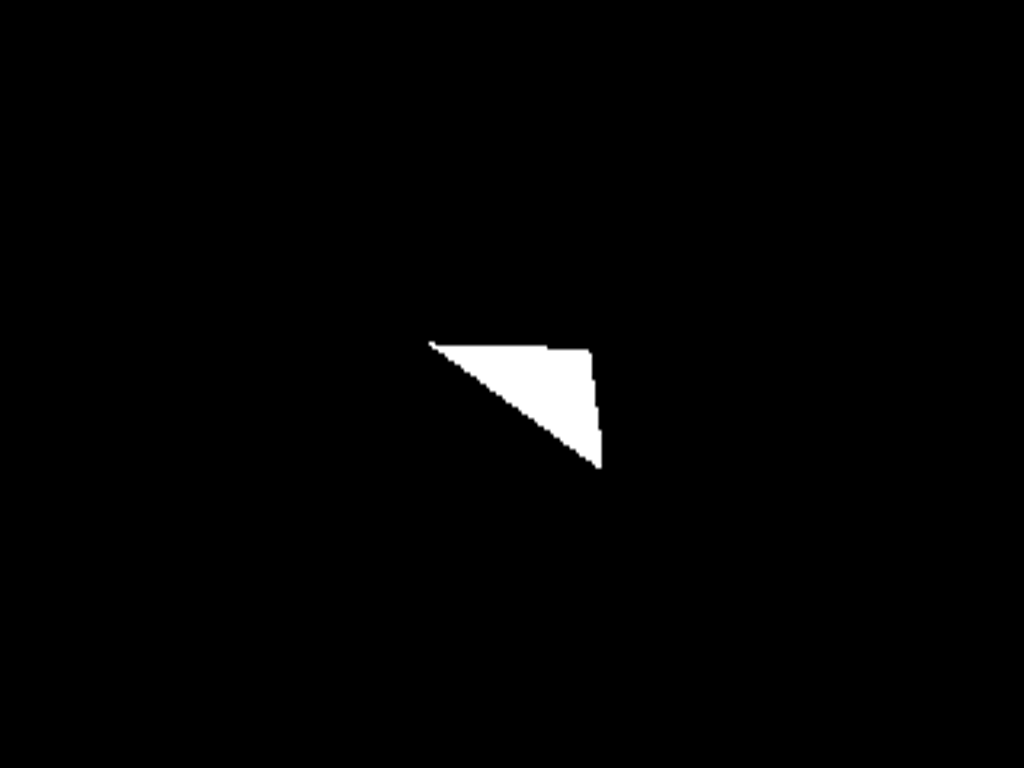

In [582]:
def draw_triangle(buffer: np.ndarray, corners: np.ndarray):
    p0, p1, p2 = np.vsplit(corners, 3)
    area = edge(p0, p1, p2)
    # bounding box
    xmin, ymin = np.min(corners, axis=0).astype(int)
    xmax, ymax = np.max(corners, axis=0).astype(int)

    x, y = np.mgrid[xmin:xmax, ymin:ymax]
    p = np.vstack([x.ravel(), y.ravel()]).T

    # evaluate all three edge functions
    e0 = edge(p0, p1, p)  # edge 0 -> 1
    e1 = edge(p1, p2, p)  # edge 1 -> 2
    e2 = edge(p2, p0, p)  # edge 2 -> 0
    inside = np.all([e0 >= 0, e1 >= 0, e2 >= 0], axis=0)
    buffer[y.ravel()[inside], x.ravel()[inside], :] = 255
    

buffer = np.zeros((h, w, 3), dtype=np.uint8)  # create new frame
screen = to_screen(orthographic(vertices[triangle, :]), resolution)
draw_triangle(buffer, screen)
show_buffer(buffer)

## Quizz time!
The edge function...
* Computes a function at the compute edge, similar to a cloud function
* Is one permutation of the three edges of the triangle
* Computes the signed distance to the line of an edge